In [1]:

######## snakemake preamble start (automatically inserted, do not edit) ########
library(methods)
Snakemake <- setClass(
    "Snakemake",
    slots = c(
        input = "list",
        output = "list",
        params = "list",
        wildcards = "list",
        threads = "numeric",
        log = "list",
        resources = "list",
        config = "list",
        rule = "character",
        bench_iteration = "numeric",
        scriptdir = "character",
        source = "function"
    )
)
snakemake <- Snakemake(
    input = list('data/ATAC_predictions_new_split/train_gaussian_smooth_trimmed_CONTROLS_split_0.05.rds', 'data/ATAC_predictions_new_split/test_gaussian_smooth_trimmed_CONTROLS_split_0.05.rds', 'data/ATACseq_250kb_bins.txt', "input_train" = 'data/ATAC_predictions_new_split/train_gaussian_smooth_trimmed_CONTROLS_split_0.05.rds', "input_test" = 'data/ATAC_predictions_new_split/test_gaussian_smooth_trimmed_CONTROLS_split_0.05.rds', "input_atac" = 'data/ATACseq_250kb_bins.txt'),
    output = list('data/ATAC_predictions_train_XX_predict_XX/all_samples_ATAC_pred_lasso_experiment_gaussian_smooth_trimmed_CONTROLS_0.05.rds', 'Trained_models/train_XX_predict_XX_models/Lasso_models/lasso_gaussian_smooth_trimmed_CONTROLS_0.05.rds', "output_pred" = 'data/ATAC_predictions_train_XX_predict_XX/all_samples_ATAC_pred_lasso_experiment_gaussian_smooth_trimmed_CONTROLS_0.05.rds', "output_model" = 'Trained_models/train_XX_predict_XX_models/Lasso_models/lasso_gaussian_smooth_trimmed_CONTROLS_0.05.rds'),
    params = list(),
    wildcards = list('gaussian_smooth_trimmed_CONTROLS', '0.05', "suffix" = 'gaussian_smooth_trimmed_CONTROLS', "percentage" = '0.05'),
    threads = 1,
    log = list('logs/processed_notebooks/train_XX_predict_XX/processed_all_samples_gaussian_smooth_trimmed_CONTROLS_0.05.r.ipynb', "notebook" = 'logs/processed_notebooks/train_XX_predict_XX/processed_all_samples_gaussian_smooth_trimmed_CONTROLS_0.05.r.ipynb'),
    resources = list('mem_mb', 'disk_mb', 'tmpdir', 'time', "mem_mb" = 200000, "disk_mb" = 10530, "tmpdir" = '/scratch/56734868', "time" = '48:00:00'),
    config = list(),
    rule = 'ATAC_pred',
    bench_iteration = as.numeric(NA),
    scriptdir = '/faststorage/project/DELFI1/Workspaces/CarmenAndAnika/20_80_experiments',
    source = function(...){
        wd <- getwd()
        setwd(snakemake@scriptdir)
        source(...)
        setwd(wd)
    }
)
setwd('/faststorage/project/DELFI1/Workspaces/CarmenAndAnika');

######## snakemake preamble end #########


# Lasso regression

In [2]:
library(tidyverse)
library(glmnet)

install.packages('glmnetUtils')
library(glmnetUtils)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand

Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loaded glmnet 2.0-16

Updating HTML index of packages in '.Library'
Making 'packages.html' ...

### Read in data and ATAC values, add ATAC values to the dataframe

In [3]:
#all_samples_controls <- readRDS("../data/experiment_ATAC_predictions/CONTROLS_split_0.05.rds")
all_samples_controls <- readRDS(snakemake@input[["input_train"]])
head(all_samples_controls)

sample,bin,X80,X81,X82,X83,X84,X85,X86,X87,...,X391,X392,X393,X394,X395,X396,X397,X398,X399,X400
PGDX16591P,chr10_400,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.689202e-06,8.502019e-06,1.350572e-05,1.879690e-05,...,9.948971e-05,8.717487e-05,7.635110e-05,7.714992e-05,7.814042e-05,7.908515e-05,7.694357e-05,8.746235e-05,9.423153e-05,1.073722e-04
PGDX16591P,chr10_40,0.000000e+00,0.000000e+00,0.000000e+00,6.220492e-06,1.127841e-05,1.791611e-05,2.493516e-05,3.040557e-05,...,6.499088e-05,7.166444e-05,9.230438e-05,1.087156e-04,1.215880e-04,1.274303e-04,1.293477e-04,1.224457e-04,1.187830e-04,1.122940e-04
PGDX16591P,chr10_4,1.014710e-05,5.596527e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.596527e-06,...,1.093832e-04,1.194377e-04,1.195697e-04,1.089153e-04,9.254578e-05,7.530921e-05,5.954999e-05,4.272815e-05,3.854870e-05,3.482194e-05
PGDX16591P,chr10_401,2.947511e-05,2.758937e-05,2.262563e-05,1.625670e-05,1.023379e-05,5.644342e-06,0.000000e+00,0.000000e+00,...,1.261676e-04,1.102738e-04,9.446936e-05,8.693500e-05,7.400178e-05,7.211603e-05,7.068258e-05,6.763284e-05,6.044879e-05,5.585934e-05
PGDX16591P,chr10_402,0.000000e+00,6.243205e-06,1.131959e-05,1.798152e-05,2.502620e-05,3.051659e-05,3.260241e-05,3.051659e-05,...,1.674453e-04,1.596526e-04,1.630259e-04,1.616209e-04,1.479629e-04,1.424678e-04,1.236895e-04,1.028254e-04,8.559672e-05,6.606091e-05
PGDX16591P,chr10_403,2.990009e-05,3.194377e-05,2.990009e-05,2.452062e-05,1.761826e-05,1.109091e-05,6.117079e-06,0.000000e+00,...,1.026767e-04,1.027918e-04,1.118344e-04,1.154010e-04,1.126550e-04,1.165966e-04,1.134356e-04,9.949908e-05,8.353553e-05,6.013216e-05


In [4]:
#ATAC <- read.table("../../../data/ATACseq_250kb_bins.txt", header = FALSE)
ATAC <- read.table(snakemake@input[["input_atac"]], header = FALSE)

colnames(ATAC) <- c("bin", "ATAC_observed")
head(ATAC)

ATAC$ATAC_observed <- as.character(ATAC$ATAC_observed)
ATAC$ATAC_observed <- as.numeric(ATAC$ATAC_observed)
ATAC$bin <- as.character(ATAC$bin)

all_samples_ATAC_controls <- inner_join(all_samples_controls, ATAC, by="bin")

head(all_samples_ATAC_controls)

bin,ATAC_observed
chr1_0,0.05376791
chr10_0,0.29698782
chr10_1,0.40893151
chr10_10,0.30582283
chr10_100,0.59316570
chr10_101,0.47641373


Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”Warning message:
“Column `bin` joining factor and character vector, coercing into character vector”

sample,bin,X80,X81,X82,X83,X84,X85,X86,X87,...,X392,X393,X394,X395,X396,X397,X398,X399,X400,ATAC_observed
PGDX16591P,chr10_400,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.689202e-06,8.502019e-06,1.350572e-05,1.879690e-05,...,8.717487e-05,7.635110e-05,7.714992e-05,7.814042e-05,7.908515e-05,7.694357e-05,8.746235e-05,9.423153e-05,1.073722e-04,0.5866651
PGDX16591P,chr10_40,0.000000e+00,0.000000e+00,0.000000e+00,6.220492e-06,1.127841e-05,1.791611e-05,2.493516e-05,3.040557e-05,...,7.166444e-05,9.230438e-05,1.087156e-04,1.215880e-04,1.274303e-04,1.293477e-04,1.224457e-04,1.187830e-04,1.122940e-04,0.1996134
PGDX16591P,chr10_4,1.014710e-05,5.596527e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.596527e-06,...,1.194377e-04,1.195697e-04,1.089153e-04,9.254578e-05,7.530921e-05,5.954999e-05,4.272815e-05,3.854870e-05,3.482194e-05,0.5968816
PGDX16591P,chr10_401,2.947511e-05,2.758937e-05,2.262563e-05,1.625670e-05,1.023379e-05,5.644342e-06,0.000000e+00,0.000000e+00,...,1.102738e-04,9.446936e-05,8.693500e-05,7.400178e-05,7.211603e-05,7.068258e-05,6.763284e-05,6.044879e-05,5.585934e-05,0.2905764
PGDX16591P,chr10_402,0.000000e+00,6.243205e-06,1.131959e-05,1.798152e-05,2.502620e-05,3.051659e-05,3.260241e-05,3.051659e-05,...,1.596526e-04,1.630259e-04,1.616209e-04,1.479629e-04,1.424678e-04,1.236895e-04,1.028254e-04,8.559672e-05,6.606091e-05,0.2319729
PGDX16591P,chr10_403,2.990009e-05,3.194377e-05,2.990009e-05,2.452062e-05,1.761826e-05,1.109091e-05,6.117079e-06,0.000000e+00,...,1.027918e-04,1.118344e-04,1.154010e-04,1.126550e-04,1.165966e-04,1.134356e-04,9.949908e-05,8.353553e-05,6.013216e-05,0.2262170


In [5]:
ATAC_val <- all_samples_ATAC_controls %>% select(ATAC_observed)
controls_predictions <- all_samples_ATAC_controls %>% select(sample, bin)
all_samples_ATAC_controls = all_samples_ATAC_controls %>% select(-c(ATAC_observed, sample, bin))

head(all_samples_ATAC_controls)
head(ATAC_val)

X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,...,X391,X392,X393,X394,X395,X396,X397,X398,X399,X400
0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.689202e-06,8.502019e-06,1.350572e-05,1.879690e-05,2.292067e-05,2.448731e-05,...,9.948971e-05,8.717487e-05,7.635110e-05,7.714992e-05,7.814042e-05,7.908515e-05,7.694357e-05,8.746235e-05,9.423153e-05,1.073722e-04
0.000000e+00,0.000000e+00,0.000000e+00,6.220492e-06,1.127841e-05,1.791611e-05,2.493516e-05,3.040557e-05,3.870430e-05,4.168398e-05,...,6.499088e-05,7.166444e-05,9.230438e-05,1.087156e-04,1.215880e-04,1.274303e-04,1.293477e-04,1.224457e-04,1.187830e-04,1.122940e-04
1.014710e-05,5.596527e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.596527e-06,1.014710e-05,2.171551e-05,...,1.093832e-04,1.194377e-04,1.195697e-04,1.089153e-04,9.254578e-05,7.530921e-05,5.954999e-05,4.272815e-05,3.854870e-05,3.482194e-05
2.947511e-05,2.758937e-05,2.262563e-05,1.625670e-05,1.023379e-05,5.644342e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.261676e-04,1.102738e-04,9.446936e-05,8.693500e-05,7.400178e-05,7.211603e-05,7.068258e-05,6.763284e-05,6.044879e-05,5.585934e-05
0.000000e+00,6.243205e-06,1.131959e-05,1.798152e-05,2.502620e-05,3.051659e-05,3.260241e-05,3.051659e-05,2.502620e-05,1.798152e-05,...,1.674453e-04,1.596526e-04,1.630259e-04,1.616209e-04,1.479629e-04,1.424678e-04,1.236895e-04,1.028254e-04,8.559672e-05,6.606091e-05
2.990009e-05,3.194377e-05,2.990009e-05,2.452062e-05,1.761826e-05,1.109091e-05,6.117079e-06,0.000000e+00,6.117079e-06,1.109091e-05,...,1.026767e-04,1.027918e-04,1.118344e-04,1.154010e-04,1.126550e-04,1.165966e-04,1.134356e-04,9.949908e-05,8.353553e-05,6.013216e-05


ATAC_observed
0.5866651
0.1996134
0.5968816
0.2905764
0.2319729
0.2262170


# Lasso regression

## Cross validation to find the best lambda and alpha

In [6]:
get_cvm <- function(model) {
   index <- match(model$lambda.min, model$lambda)
  model$cvm[index]
}

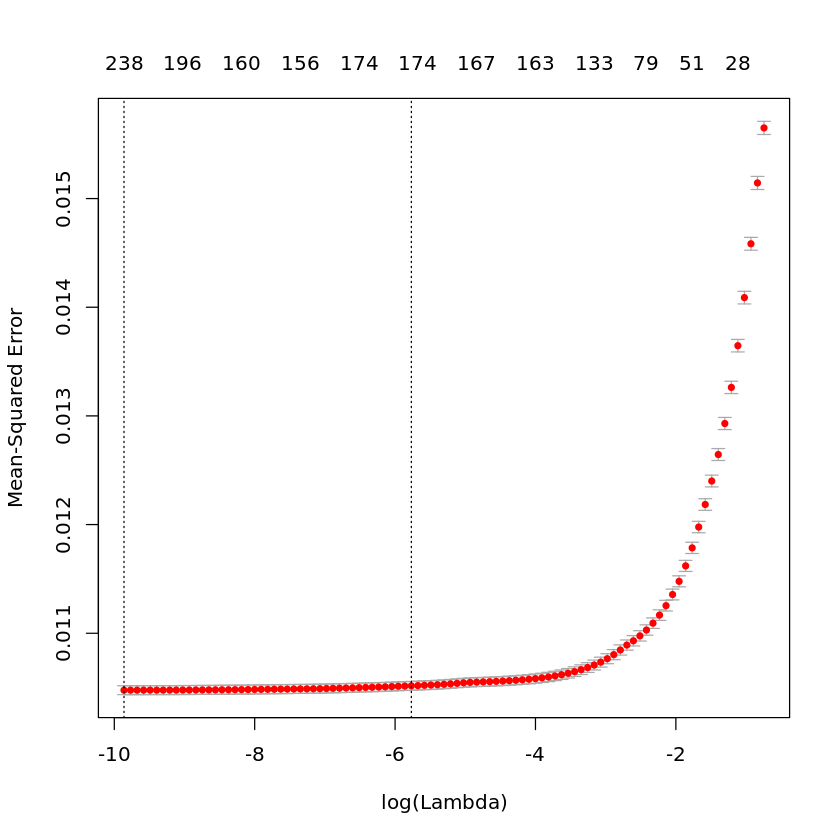

In [7]:
set.seed(0)

y <- ATAC_val %>% as.matrix()
X <- all_samples_ATAC_controls %>% as.matrix()

######### finding the best alpha #########
set.seed(0)
lasso_cva <- glmnetUtils::cva.glmnet(X, y, nfolds = 10)
enet_performance <- data.frame(alpha = lasso_cva$alpha)
models <- lasso_cva$modlist
enet_performance$cvm <- vapply(models, get_cvm, numeric(1))

minix <- which.min(enet_performance$cvm)
best_alpha <- lasso_cva$alpha[minix]
###########################################

######### finding the best lambda #########
set.seed(0)
lasso_cv <- glmnet::cv.glmnet(X, y, alpha = best_alpha,
                      standardize = TRUE, nfolds = 10)

plot(lasso_cv)
###########################################

In [8]:
(lambda_cv <- lasso_cv$lambda.min)

[1] 5.213293e-05

## Fit the model on all traindata controls

In [9]:
y <- ATAC_val %>% as.matrix()
X <- all_samples_ATAC_controls %>% as.matrix()

fit       <- glmnet::glmnet(X, y, alpha = best_alpha, lambda = lambda_cv, standardize = TRUE)
# saving the model
saveRDS(fit, snakemake@output[["output_model"]])


## Predict on normalized 20% of controls using the model (fitted on train controls) and save the predictions to file

In [10]:
#filename = "../../../data/all_samples_normalized_CASES.csv"
#test_data = readRDS("../../data/20_80_splits/20_all_samples_normalized_CONTROLS.rds")

test_data = readRDS(snakemake@input[["input_test"]])

In [11]:
head(test_data)

sample,bin,X80,X81,X82,X83,X84,X85,X86,X87,...,X391,X392,X393,X394,X395,X396,X397,X398,X399,X400
PGDX16568P,chr10_400,2.656112e-05,2.994814e-05,2.961085e-05,2.929903e-05,3.469718e-05,3.917019e-05,4.629696e-05,5.955899e-05,...,1.797668e-04,1.753154e-04,1.569416e-04,0.0001385816,1.166854e-04,9.841735e-05,8.478873e-05,7.355554e-05,6.464917e-05,7.007278e-05
PGDX16568P,chr10_40,2.639605e-05,3.960356e-05,5.284513e-05,6.279401e-05,6.650374e-05,6.279401e-05,5.284513e-05,3.960356e-05,...,1.239199e-04,1.143096e-04,1.096515e-04,0.0001061073,1.087833e-04,1.047829e-04,9.925148e-05,8.919007e-05,7.883794e-05,7.639961e-05
PGDX16568P,chr10_4,4.192713e-05,6.023358e-05,7.256827e-05,7.906282e-05,7.854465e-05,7.167697e-05,7.860718e-05,8.606324e-05,...,1.251224e-04,1.238579e-04,1.192868e-04,0.0001246347,1.214730e-04,1.148990e-04,1.029420e-04,8.920670e-05,7.138334e-05,5.295770e-05
PGDX16568P,chr10_401,0.000000e+00,0.000000e+00,0.000000e+00,5.920236e-06,1.073402e-05,1.705132e-05,3.557204e-05,5.040596e-05,...,2.383188e-04,2.242108e-04,1.921067e-04,0.0001600517,1.301008e-04,1.037432e-04,8.040869e-05,7.337752e-05,8.314214e-05,8.566120e-05
PGDX16568P,chr10_402,2.723749e-05,3.321301e-05,3.548313e-05,3.321301e-05,2.723749e-05,2.636520e-05,3.143441e-05,4.547983e-05,...,3.955727e-05,3.316005e-05,2.463956e-05,0.0000263652,4.082719e-05,7.144226e-05,9.926339e-05,1.268287e-04,1.481385e-04,1.569626e-04
PGDX16568P,chr10_403,3.026954e-05,3.233848e-05,3.026954e-05,2.482360e-05,1.783596e-05,1.122795e-05,1.857799e-05,2.245591e-05,...,2.366995e-04,2.341484e-04,2.196942e-04,0.0002026050,1.707937e-04,1.339162e-04,9.654238e-05,6.627284e-05,4.648453e-05,3.525657e-05


In [12]:
test_data_samples_bin_rm <- test_data %>% select(-c("sample", "bin")) %>% as.matrix()
tmp <- as.vector(predict(fit, s=lambda_cv, test_data_samples_bin_rm))

In [13]:
pred_tibble <- tibble(sample = test_data$sample, bin = test_data$bin)
pred_tibble <- inner_join(pred_tibble, ATAC, by="bin")
pred_tibble <- pred_tibble %>% mutate(ATAC_predicted = tmp)

Warning message:
“Column `bin` joining factor and character vector, coercing into character vector”

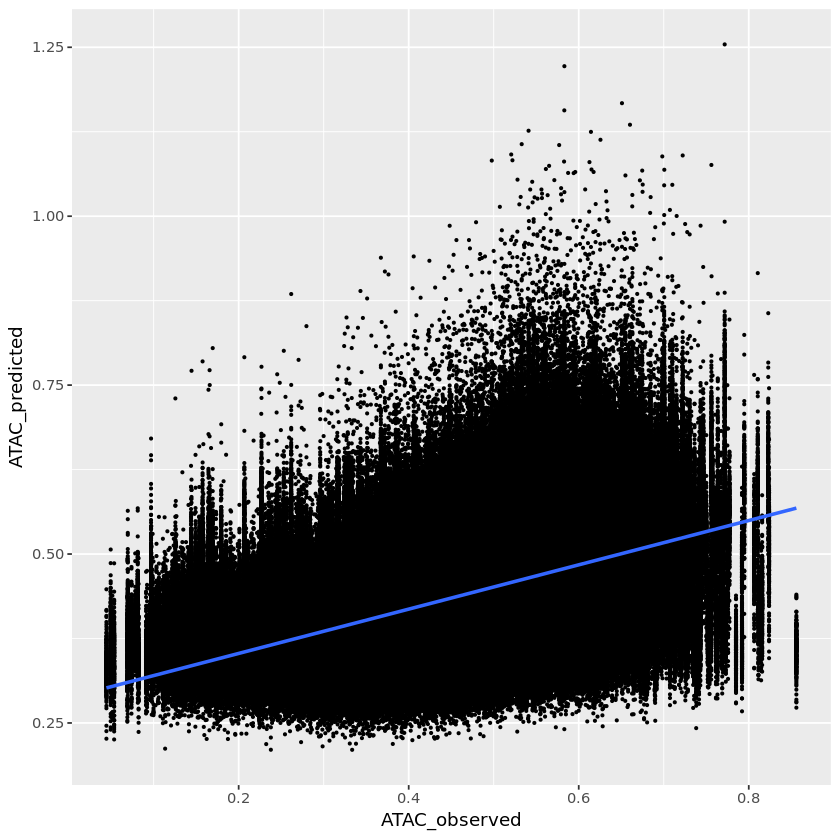

In [14]:
ggplot(pred_tibble, aes(x = ATAC_observed, y = ATAC_predicted)) + 
    geom_point(size = 0.5) + 
    geom_smooth(method = "lm", formula = y~x)

In [15]:
cor(pred_tibble$ATAC_observed, pred_tibble$ATAC_predicted)

[1] 0.5306819

In [16]:
ae    <- abs(pred_tibble$ATAC_observed - pred_tibble$ATAC_predicted)
(mae   <- mean(ae))

[1] 0.08274758

In [17]:
se    <- (pred_tibble$ATAC_observed - pred_tibble$ATAC_predicted)^2
mse   <- mean(se)
(rmse <- sqrt(mse))

[1] 0.106641

In [18]:
saveRDS(pred_tibble, file = snakemake@output[["output_pred"]])